# Autoencoder for MNIST:
This notebook constructs a 3-layer denoising autoencoder to ecnode MNIST data based on exercise 8 in [Hands-on Machine Learning with Scikit-Learn and TensorFlow](http://shop.oreilly.com/product/0636920052289.do) chapter 15.

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Read Data

In [3]:
mnist = input_data.read_data_sets("/tmp/data/")

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [4]:
X_train = mnist.train.images
y_train = mnist.train.images
X_valid = mnist.validation.images
y_valid = mnist.validation.images
X_test = mnist.test.images
y_test = mnist.test.images

In [5]:
print len(X_train), len(X_valid), len(X_test)

55000 5000 10000


### Construct Autoencoder

**Hyperparameters:**  
Shape of inputs/outputs, neurons for hidden layers, encoding dimension, l2 regularization weight, and noise level for adding to inputs

In [6]:
n_inputs = 28*28  # MNIST
n_outputs = n_inputs
n_neur = [250]
encode_dim = 100
noise_level = 1.0
l2_reg = 0.0001

In [7]:
tf.reset_default_graph()

**Autoencoding strcuture**

In [8]:
X = tf.placeholder(shape=[None, n_inputs], dtype=tf.float32, name='X')
y = tf.placeholder(shape=None, dtype=tf.int64, name='y')

initializer = tf.contrib.layers.variance_scaling_initializer()
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)

X_noised = X + noise_level * tf.random_normal(shape=tf.shape(X))
hidden_activations = [tf.nn.relu]
encode_activation = tf.nn.relu

# - Parameters
# --- Encoding
# encoding hidden layer params
W_input_hidden = tf.Variable(initial_value=initializer([n_inputs, n_neur[0]]))
b_input_hidden = tf.Variable(initial_value=tf.zeros(n_neur[0]))
# encoding layer params
W_hidden_encode = tf.Variable(initial_value=initializer([n_neur[0], encode_dim]))
b_hidden_encode = tf.Variable(initial_value=tf.zeros(encode_dim))
# --- Decoding
# hidden decoding layer params
W_encode_hidden = tf.transpose(W_hidden_encode)
b_encode_hidden = tf.Variable(initial_value=tf.zeros(n_neur[0]))
# output decoding layer params
W_hidden_output = tf.transpose(W_input_hidden)
b_hidden_output = tf.Variable(initial_value=tf.zeros(n_outputs))

# - Layers
# --- Encoding
# hidden layer
hidden_encode_fc = hidden_activations[0](tf.matmul(X_noised, W_input_hidden) + b_input_hidden)
# encoding layer
encode_fc = encode_activation(tf.matmul(hidden_encode_fc, W_hidden_encode) + b_hidden_encode)
# --- Decoding
# hidden decoding layer
hidden_decode_fc = hidden_activations[0](tf.matmul(encode_fc, W_encode_hidden) + b_encode_hidden)
# output decoding layer
output_fc = tf.matmul(hidden_decode_fc, W_hidden_output) + b_hidden_output

In [9]:
learning_rate = 0.01

reconstruction_loss = tf.reduce_mean(tf.square(output_fc - X))
reg_loss = regularizer(W_input_hidden) + regularizer(W_hidden_encode)
loss = reconstruction_loss + reg_loss
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

**Training**   
This training procedure implements early stopping to avoid overfitting. The stopping scheme works as follows: store the best loss value as a new one is encountered, if this value has not changed in 8 iterations, preserve the model that achieved this loss and stop training.

In [10]:
n_epochs = 50
saver = tf.train.Saver()
batch_size = 500
stopping_threshold = 5
iter_since_best = 0
best_loss_val = float('inf')

In [11]:
n_samples = X_train.shape[0]

In [12]:
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(n_epochs):
        rand_idx = np.random.permutation(np.arange(n_samples))
        for iteration in range(n_samples // batch_size):
            batch_idx = rand_idx[(iteration*batch_size):((iteration+1)*batch_size)]
            X_batch = X_train[batch_idx,:]
            y_batch = y_train[batch_idx]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val = sess.run(loss, feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Training loss (MSE):", loss_val, "Testing loss (MSE):", loss_val, "Iterations since best", iter_since_best)
        if loss_val < best_loss_val:
            save_path = saver.save(sess, "./my_mnist_autoencoder.ckpt")
            best_loss_val = loss_val
            iter_since_best = 0
        if iter_since_best >= stopping_threshold:
            break
        iter_since_best +=1
with tf.Session() as sess:
    saver.restore(sess, "./my_mnist_autoencoder.ckpt")
    loss_test = loss.eval(feed_dict={X: X_test, y: y_test})
    print("Final test loss: {:.5f}%".format(loss_test))

(0, 'Training loss (MSE):', 0.077020057, 'Testing loss (MSE):', 0.077020057, 'Iterations since best', 0)
(1, 'Training loss (MSE):', 0.055149544, 'Testing loss (MSE):', 0.055149544, 'Iterations since best', 1)
(2, 'Training loss (MSE):', 0.045227669, 'Testing loss (MSE):', 0.045227669, 'Iterations since best', 1)
(3, 'Training loss (MSE):', 0.043512918, 'Testing loss (MSE):', 0.043512918, 'Iterations since best', 1)
(4, 'Training loss (MSE):', 0.040784717, 'Testing loss (MSE):', 0.040784717, 'Iterations since best', 1)
(5, 'Training loss (MSE):', 0.039580051, 'Testing loss (MSE):', 0.039580051, 'Iterations since best', 1)
(6, 'Training loss (MSE):', 0.039056432, 'Testing loss (MSE):', 0.039056432, 'Iterations since best', 1)
(7, 'Training loss (MSE):', 0.038830761, 'Testing loss (MSE):', 0.038830761, 'Iterations since best', 1)
(8, 'Training loss (MSE):', 0.03843715, 'Testing loss (MSE):', 0.03843715, 'Iterations since best', 1)
(9, 'Training loss (MSE):', 0.038580757, 'Testing loss (M

### Visualizing decoding of test data based on fit autoencoder

In [13]:
n_test_digits = 10
X_test_vis = mnist.test.images[:n_test_digits]

INFO:tensorflow:Restoring parameters from ./my_mnist_autoencoder.ckpt


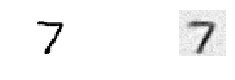

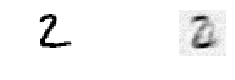

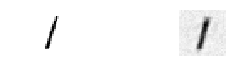

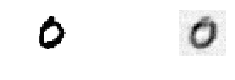

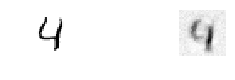

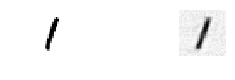

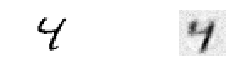

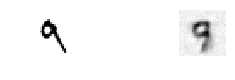

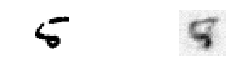

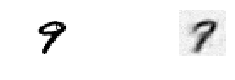

In [14]:
with tf.Session() as sess:
    saver.restore(sess, "./my_mnist_autoencoder.ckpt")
    outputs_val = output_fc.eval(feed_dict={X: X_test_vis})

def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")

for digit_index in range(n_test_digits):
    plt.figure(figsize=(5,10))
    plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
    plot_image(X_test[digit_index])
    plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
    plot_image(outputs_val[digit_index])

### Classifier based on encodings

In [15]:
y_train_pred = mnist.train.labels
y_valid_pred = mnist.validation.labels
y_test_pred = mnist.test.labels

In [51]:
n_outputs_pred = 10
n_neur_pred = [250,50]

In [52]:
y_pred_actual = tf.placeholder(shape=[None], dtype=tf.int32, name='y_pred_actual')

In [53]:
predict_fc_hidden = tf.layers.dense(encode_fc, n_neur_pred[0], activation=tf.nn.relu)
predict_fc_hidden_2 = tf.layers.dense(encode_fc, n_neur_pred[1], activation=tf.nn.relu)
logits = tf.layers.dense(predict_fc_hidden, n_outputs_pred)

In [54]:
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_pred_actual, logits=logits)
pred_loss = tf.reduce_mean(xentropy, name='loss')
correct = tf.nn.in_top_k(logits, y_pred_actual, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [55]:
dense_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='dense')

In [56]:
learning_rate = 0.01
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_step = optimizer.minimize(pred_loss, name='training_step', var_list=dense_vars)

In [57]:
n_epochs = 25
batch_size = 500
stopping_threshold = 5
iter_since_best = 0
best_loss_val = float('inf')

In [58]:
n_samples = X_train.shape[0]

In [59]:
partial_init = tf.variables_initializer(var_list=dense_vars)

In [60]:
with tf.Session() as sess:
    sess.run(partial_init)
    saver.restore(sess, "./my_mnist_autoencoder.ckpt")
    for epoch in range(n_epochs):
        rand_idx = np.random.permutation(np.arange(n_samples))
        for iteration in range(n_samples // batch_size):
            batch_idx = rand_idx[(iteration*batch_size):((iteration+1)*batch_size)]
            X_batch = X_train[batch_idx,:]
            y_batch = y_train_pred[batch_idx]
            sess.run(training_op, feed_dict={X: X_batch, y_pred_actual: y_batch})
        loss_val, acc_val = sess.run([pred_loss, accuracy], feed_dict={X: X_valid, y_pred_actual: y_valid_pred})
        print(epoch, "Testing loss:", loss_val, 'Testing Accuracy:', acc_val, "Iterations since best", iter_since_best)
        if loss_val < best_loss_val:
            save_path = saver.save(sess, "./my_mnist_autoencoder_pred.ckpt")
            best_loss_val = loss_val
            iter_since_best = 0
        if iter_since_best >= stopping_threshold:
            break
        iter_since_best +=1
#with tf.Session() as sess:
#    saver.restore(sess, "./my_mnist_autoencoder_pred.ckpt")
#    acc_val = accuracy.eval(feed_dict={X: X_test, y: y_test_pred})
#    print("Final test accuracy: {:.5f}%".format(acc_val))

INFO:tensorflow:Restoring parameters from ./my_mnist_autoencoder.ckpt
(0, 'Testing loss:', 2.4675536, 'Testing Accuracy:', 0.1216, 'Iterations since best', 0)
(1, 'Testing loss:', 2.4911981, 'Testing Accuracy:', 0.1122, 'Iterations since best', 1)
(2, 'Testing loss:', 2.4779491, 'Testing Accuracy:', 0.1162, 'Iterations since best', 2)
(3, 'Testing loss:', 2.4888806, 'Testing Accuracy:', 0.1148, 'Iterations since best', 3)
(4, 'Testing loss:', 2.4946651, 'Testing Accuracy:', 0.1108, 'Iterations since best', 4)
(5, 'Testing loss:', 2.4852676, 'Testing Accuracy:', 0.1156, 'Iterations since best', 5)


INFO:tensorflow:Restoring parameters from ./my_mnist_autoencoder_pred.ckpt


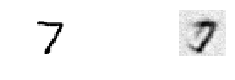

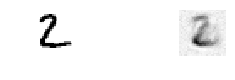

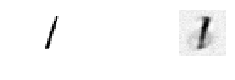

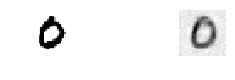

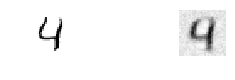

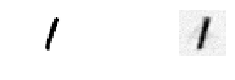

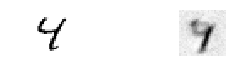

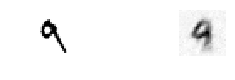

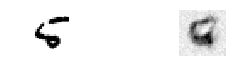

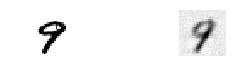

In [50]:
with tf.Session() as sess:
    saver.restore(sess, "./my_mnist_autoencoder_pred.ckpt")
    outputs_val = output_fc.eval(feed_dict={X: X_test_vis})

def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")

for digit_index in range(n_test_digits):
    plt.figure(figsize=(5,10))
    plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
    plot_image(X_test[digit_index])
    plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
    plot_image(outputs_val[digit_index])